## Objective: 
1. Extract 66(1+4+4+4+4+4+6+9+5+25)features from HbO
    - Input: Subject, Channel, TimeSamplePoint, HbType

    - Output: [TemporalFeatures, SpatialFeatures] 
    TemporalFeatures Subject x Channel x Features(6*3*2)

    - Requirement: 
        - index_task_start: datapoint of Acitvating-Task start
            For example: you have 1250 datapoint with the sampling rate of 10Hz. The task starts at 10s. So you index_start would be 100=10s*10Hz
        - index_task_end: datapoint of Acitvating-Task end

        - fs: sampling rate (Hz)


Ref: Wang, Rui, et al. "Depression analysis and recognition based on functional near-infrared spectroscopy." IEEE journal of biomedical and health informatics 25.12 (2021): 4289-4299.


In [2]:
import numpy as np 
import matplotlib.pyplot as plt 
from scipy.signal import welch
import pywt



In [3]:
# input = np.random.rand(458, 52, 125)
# please make sure the input data is normalized using something like z-norm
def normalize(data):
    # Iterate over each subject
    normalized_data = np.empty_like(data)
    for i in range(data.shape[0]):
        # Calculate the mean and standard deviation for the current subject
        mean = np.mean(data[i, :, :])
        std = np.std(data[i, :, :])

        # Perform z-normalization for the current subject
        normalized_data[i, :, :] = (data[i, :, :] - mean) / std
    return normalized_data



# Choose
hbo_main_path = '/Users/shanxiafeng/Documents/Code/python/fnirs_DL/JinyuanWang_pythonCode/allData/Output_npy/twoDoctor/HbO-All-Lowmid-High/correct_channel_data.npy'
hbr_main_path = '/Users/shanxiafeng/Documents/Code/python/fnirs_DL/JinyuanWang_pythonCode/allData/Output_npy/twoDoctor/HbR-All-Lowmid-High/correct_channel_data.npy'

# hbo_main_path = '/Users/shanxiafeng/Documents/Code/python/fnirs_DL/JinyuanWang_pythonCode/allData/Output_npy/twoDoctor/HbO-All-HC-MDD/correct_channel_data.npy'
# hbr_main_path = '/Users/shanxiafeng/Documents/Code/python/fnirs_DL/JinyuanWang_pythonCode/allData/Output_npy/twoDoctor/HbR-All-HC-MDD/correct_channel_data.npy'



input = np.load(hbo_main_path)
input = normalize(np.transpose(input, (0, 2, 1)))

index_task_start = 10
index_task_end = 70
fs = 1  # sampling rate

# 1. Total: Sum of hemoglobin concentration changes in the whole process.
feature_1 = np.sum(input, axis=2)[..., np.newaxis]
print(f'feature 1 shape -> {feature_1.shape}')

# 2. Peak: Peak value of hemoglobin concentration changes in four periods.
feature_2 = np.concatenate(
    (np.max(input[..., :index_task_start], axis=2)[..., np.newaxis],
     np.max(input[..., index_task_start:index_task_end],
            axis=2)[..., np.newaxis],
     np.max(input[..., :index_task_end:], axis=2)[..., np.newaxis],
     np.max(input[..., :], axis=2)[..., np.newaxis]),
    axis=2
)
print(f'feature 2 shape -> {feature_2.shape}')

# 3. Valley: Valley value of hemoglobin concentration changes in four periods.
feature_3 = np.concatenate(
    (np.min(input[..., :index_task_start], axis=2)[..., np.newaxis],
     np.min(input[..., index_task_start:index_task_end],
            axis=2)[..., np.newaxis],
     np.min(input[..., :index_task_end:], axis=2)[..., np.newaxis],
     np.min(input[..., :], axis=2)[..., np.newaxis]),
    axis=2
)
print(f'feature 3 shape -> {feature_3.shape}')

# 4. Average: Mean value of hemoglobin concentration changes in four periods.
feature_4 = np.concatenate(
    (np.mean(input[..., :index_task_start], axis=2)[..., np.newaxis],
     np.mean(input[..., index_task_start:index_task_end],
             axis=2)[..., np.newaxis],
     np.mean(input[..., :index_task_end:], axis=2)[..., np.newaxis],
     np.mean(input[..., :], axis=2)[..., np.newaxis]),
    axis=2
)
print(f'feature 4 shape -> {feature_4.shape}')

# 5. Variance: Variance of hemoglobin concentration changes in four periods.
feature_5 = np.concatenate(
    (np.var(input[..., :index_task_start], axis=2)[..., np.newaxis],
     np.var(input[..., index_task_start:index_task_end],
            axis=2)[..., np.newaxis],
     np.var(input[..., :index_task_end:], axis=2)[..., np.newaxis],
     np.var(input[..., :], axis=2)[..., np.newaxis]),
    axis=2
)
print(f'feature 5 shape -> {feature_5.shape}')

# 6. Integral: Integral of hemoglobin concentration changes in four periods.
feature_6 = np.concatenate(
    (np.sum(input[..., :index_task_start], axis=2)[..., np.newaxis],
     np.sum(input[..., index_task_start:index_task_end],
            axis=2)[..., np.newaxis],
     np.sum(input[..., :index_task_end:], axis=2)[..., np.newaxis],
     np.sum(input[..., :], axis=2)[..., np.newaxis]),
    axis=2
)
print(f'feature 6 shape -> {feature_6.shape}')


def compute_linear_fitting(input):
    time = np.array(list(range(input.shape[-1])))
    n = len(time)
    sum_x = np.sum(time)
    sum_y = np.sum(input, axis=2)
    sum_x_squared = np.sum(time ** 2)
    sum_xy = np.sum(time * input, axis=2)

    m = (n * sum_xy - sum_x * sum_y) / (n * sum_x_squared - sum_x ** 2)

    b = (sum_y - m * sum_x) / n

    concatenate_m_b = np.concatenate(
        (m[..., np.newaxis], b[..., np.newaxis]), axis=-1)
    return concatenate_m_b  # slope and intercept


feature_7 = np.concatenate(
    (compute_linear_fitting(input[..., :index_task_start]),
     compute_linear_fitting(input[..., index_task_start:index_task_end]),
     compute_linear_fitting(input[..., :index_task_end:])),
    axis=2
)
print(f'feature 7 shape -> {feature_7.shape}')

time = np.array(list(range(input.shape[-1])))
feature_8 = np.zeros((input.shape[0], input.shape[1], 9))
for i in range(input.shape[0]):
    for j in range(input.shape[1]):
        # Fit a quadratic function (degree 2 polynomial) to the data
        # coefficients[0] is a, coefficients[1] is b, and coefficients[2] is c in the equation ax^2 + bx + c
        # the 2 specifies a quadratic function
        a1, b1, c1 = np.polyfit(
            time[:index_task_start], input[i, j, :index_task_start], 2)
        a2, b2, c2 = np.polyfit(
            time[index_task_start:index_task_end], input[i, j, index_task_start:index_task_end], 2)
        a3, b3, c3 = np.polyfit(
            time[index_task_end:], input[i, j, index_task_end:], 2)
        feature_8[i, j] = [a1, b1, c1, a2, b2, c2, a3, b3, c3]
print(f'feature 8 shape -> {feature_8.shape}')


def compute_power_features(signal, fs):
    # Compute power spectral density using Welch's method
    f, Pxx_den = welch(signal, fs)

    # Find the indices corresponding to the frequency bands
    idx_band1 = np.where((f >= 0.01) & (f <= 0.25))
    idx_band2 = np.where((f >= 0.25) & (f <= 0.5))

    # Feature 1: maximum power in the first frequency band
    Pnu1 = np.max(Pxx_den[idx_band1])

    # Feature 2: maximum power in the second frequency band
    Pnu2 = np.max(Pxx_den[idx_band2])

    # Find index closest to 0.01 Hz and 0.25 Hz
    idx_closest_001 = np.argmin(np.abs(f - 0.01))
    idx_closest_025 = np.argmin(np.abs(f - 0.25))

    # Feature 3: subtract power at 0.01 Hz from maximum power in first frequency band
    Pnu10 = Pxx_den[idx_closest_001]
    feature3 = Pnu1 - Pnu10

    # Feature 4: subtract power at 0.25 Hz from maximum power in second frequency band
    Pnu20 = Pxx_den[idx_closest_025]
    feature4 = Pnu2 - Pnu20

    # Feature 5: ratio of feature 4 to feature 3
    feature5 = feature4 / feature3

    return Pnu1, Pnu2, feature3, feature4, feature5


feature_9 = np.zeros((input.shape[0], input.shape[1], 5))
for i in range(input.shape[0]):
    for j in range(input.shape[1]):
        feature_9[i, j] = compute_power_features(input[i, j], fs)
print(f'feature 9 shape -> {feature_9.shape}')


q = np.mean(input)  # threhold
print(f'threshold is set to {q} ')


def entropy_wsh(y):
    return -np.sum(y*y * np.log10(y*y), axis=1)


def entropy_we(y):
    return np.sum(y, axis=1)


def entropy_wp(y):
    t1 = np.abs(y) ** 2
    t2 = np.linalg.norm(y, ord=2, axis=1) ** 2 / y.shape[1]
    # original should be
    # t2 = np.linalg.norm(y, ord=norm_q) ** norm_q
    # but this will cause the value to be 1000x time compared to other entropy values.
    # So I added / y.shape[1]
    return np.sum(t1-t2[..., np.newaxis], axis=1)


def entropy_wt(y):
    b = np.where(y > q, 1, 0)
    return np.sum(b, axis=1)


def entropy_wsu(y):
    t1 = y.shape[0]
    t2 = np.sum(np.where(y > q, 0, 1), axis=1)
    t3 = min(np.min(y**2), q**2)
    return t1 - t2 + t3

# Bacuse using wavelet decomposition will

def calculte_entropy(x):
    coeffs = pywt.wavedec(x, 'db6', level=4)
    max_length = max(len(coeff) for coeff in coeffs)
    y = np.array([np.pad(coeff, (0, max_length - len(coeff)),
                 constant_values=(q)) for coeff in coeffs])
    return np.concatenate((entropy_wsh(y), entropy_we(y), entropy_wp(y), entropy_wt(y), entropy_wsu(y)), axis=0)

feature_10 = np.zeros((input.shape[0], input.shape[1], 25))
for i in range(input.shape[0]):
    for j in range(input.shape[1]):
        feature_10[i, j] = calculte_entropy(input[i, j])
print(f'feature 10 shape -> {feature_10.shape}')

nor_all_feature = np.concatenate(
    (normalize(feature_1),
     normalize(feature_2),
     normalize(feature_3),
     normalize(feature_4),
     normalize(feature_5),
     normalize(feature_6),
     normalize(feature_7),
     normalize(feature_8),
     normalize(feature_9),
     normalize(feature_10)),
    axis=2
)

all_feature = np.concatenate(
    (feature_1,
     feature_2,
     feature_3,
     feature_4,
     feature_5,
     feature_6,
     feature_7,
     feature_8,
     feature_9,
     feature_10),
    axis=2
)



feature 1 shape -> (216, 52, 1)
feature 2 shape -> (216, 52, 4)
feature 3 shape -> (216, 52, 4)
feature 4 shape -> (216, 52, 4)
feature 5 shape -> (216, 52, 4)
feature 6 shape -> (216, 52, 4)
feature 7 shape -> (216, 52, 6)
feature 8 shape -> (216, 52, 9)


/Users/shanxiafeng/miniconda3/lib/python3.9/site-packages/scipy/signal/_spectral_py.py:2017: UserWarning: nperseg = 256 is greater than input length  = 125, using nperseg = 125
  warnings.warn('nperseg = {0:d} is greater than input length '
/var/folders/dj/c5r3qbs52hg_qgrqgmmp61_m0000gn/T/ipykernel_46099/803667512.py:162: RuntimeWarning: invalid value encountered in scalar divide
  feature5 = feature4 / feature3


feature 9 shape -> (216, 52, 5)
threshold is set to 4.696464806163625e-18 


/Users/shanxiafeng/miniconda3/lib/python3.9/site-packages/pywt/_multilevel.py:43: UserWarning: Level value of 4 is too high: all coefficients will experience boundary effects.
  warnings.warn(


feature 10 shape -> (216, 52, 25)


/var/folders/dj/c5r3qbs52hg_qgrqgmmp61_m0000gn/T/ipykernel_46099/803667512.py:179: RuntimeWarning: divide by zero encountered in log10
  return -np.sum(y*y * np.log10(y*y), axis=1)
/var/folders/dj/c5r3qbs52hg_qgrqgmmp61_m0000gn/T/ipykernel_46099/803667512.py:179: RuntimeWarning: invalid value encountered in multiply
  return -np.sum(y*y * np.log10(y*y), axis=1)


In [6]:
# Based on individual subject, do normalization
print(f'feature all shape -> {all_feature.shape}')
nor_individual_subject_processed_all_feature = np.nan_to_num(nor_all_feature)

save_fold = '/Users/shanxiafeng/Documents/Code/python/fnirs_DL/JinyuanWang_pythonCode/allData/data_for_reproducing_model/HbO-All-Lowmid-High/wang_alex'

def check_create_path(feature_save_path):
    import os
    if not os.path.exists(feature_save_path):
        print('Hello')
        os.makedirs(feature_save_path)
check_create_path(save_fold)

np.save(save_fold + '/data', nor_individual_subject_processed_all_feature)



# Based on all subject, do normalization
def normalize_all_subject(data):
    # Iterate over each subject
    normalized_data = np.empty_like(data)
    # Calculate the mean and standard deviation for the current subject
    mean = np.mean(data)
    std = np.std(data)

    # Perform z-normalization for the current subject
    normalized_data = (data - mean) / std
    return normalized_data

processed_all_feature = np.nan_to_num(all_feature)
nor_all_processed_all_feature = normalize_all_subject(processed_all_feature)

np.save(save_fold + '/nor_allsubject_data', nor_all_processed_all_feature)

feature all shape -> (216, 52, 66)
Hello


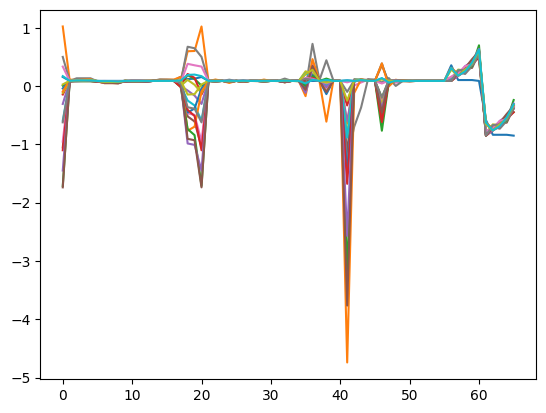

In [13]:

ni = 10
nj = 2
plt.figure()

for i in range(ni):
    for j in range(nj):
        plt.plot(nor_all_processed_all_feature[i, j])

In [3]:


all_feature = np.concatenate(
    (normalize(feature_1),
     normalize(feature_2),
     normalize(feature_3),
     normalize(feature_4),
     normalize(feature_5),
     normalize(feature_6),
     normalize(feature_7),
     normalize(feature_8),
     normalize(feature_9),
     normalize(feature_10)),
    axis=2
)
print(all_feature.shape)

(458, 52, 66)


In [27]:
y = np.random.randn(5,10)
np.linalg.norm(y, ord=0.5, axis=1)**0.5

array([ 7.55132919,  7.12540695, 10.10482202,  8.68971172,  9.60094434])

In [18]:
# def compute_wavelet_features():

from scipy.stats import gaussian_kde
data = np.random.randn(1000)

# Perform Discrete Wavelet Transform using db6 wavelet
# Set the level to 2 for decomposing the signal into two levels of approximation and detail coefficients.
coeffs = pywt.wavedec(data, 'db6', level=4)

for i, coef in coeffs:
    print(coef)

[ 0.66871738  1.21223813  1.27828083  0.91124601  0.86354382  0.73530997
  1.52646545  0.88399615  1.36296357 -1.64776702  0.53045915  0.46836056
  0.60329055  0.00695352  1.89151522  0.03363845  0.35217586 -0.90522447
 -0.59113834  0.64471833 -0.7648853  -0.3230293  -0.49984589 -1.51134921
  1.63188702 -0.85273299 -1.02556022 -0.52127826  1.45513075 -2.1551689
 -0.4159514   2.09576738 -0.3438627   0.7702089  -2.40107717  0.45000842
  0.40819821  0.87400439 -1.64283604 -0.61900885  0.23672007 -1.05622569
 -0.4810641   0.58501651 -0.67139472  1.06797287 -0.56349994  1.13372922
 -0.19872932 -1.92250273  0.67826314 -0.4253755  -0.72581779 -0.19406729
 -0.71723917  0.98095655 -0.22107287 -0.91389443  0.21000864 -0.01021925
 -0.13303797  0.67906178 -2.2155711   0.43214856 -0.4966268   0.32327645
  0.84012512  0.15366693  1.14570745  1.38121869 -1.10589376 -1.60875232]
[-0.00611678  0.22354036  1.03930563  0.87360998  0.27810154 -0.4952355
  0.47238686 -0.04146763 -1.22151644  0.21853035  0.

In [8]:
q = np.mean(input)  # threhold
print(q)




b = np.array([[100, 100, 100], [10, 10, 10], [100, 100, 100],
             [100, 100, 100], [100, 100, 100]])
a = np.array([[1, 0, 2, 0, 3, 0], [1, 0, 2, 0, 3, 0], [
             1, 0, 2, 0, 3, 0], [1, 0, 2, 0, 3, 0], [1, 0, 2, 0, 3, 0]])
print(entropy_wsh(b))
print(entropy_we(b))
print(entropy_wp(b))
print(entropy_wt(b))
print(entropy_wsu(b))

print(calculte_entropy(b))

0.5001608635506714
[-120000.    -600. -120000. -120000. -120000.]
[300  30 300 300 300]
[-330900. -360600. -330900. -330900. -330900.]
[3 3 3 3 3]
[5.25016089 5.25016089 5.25016089 5.25016089 5.25016089]


/var/folders/08/nbds20c160ng75y7q6lyzw_00000gn/T/ipykernel_80396/643394445.py:167: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  y = np.array([np.pad(coeff, (0, max_length - len(coeff)), constant_values=(q)) for coeff in coeffs])


ValueError: could not broadcast input array from shape (5,10) into shape (5,)

In [3]:
import numpy as np

def compute_power_features(signal, fs):
    # Compute power spectral density using Welch's method
    f, Pxx_den = welch(signal, fs, nperseg=1024)
    
    print(Pxx_den)

    # Find the indices corresponding to the frequency bands
    idx_band1 = np.where((f >= 0.01) & (f <= 0.25))
    idx_band2 = np.where((f >= 0.25) & (f <= 0.5))

    # Feature 1: maximum power in the first frequency band
    Pnu1 = np.max(Pxx_den[idx_band1])

    # Feature 2: maximum power in the second frequency band
    Pnu2 = np.max(Pxx_den[idx_band2])

    # Find index closest to 0.01 Hz and 0.25 Hz
    idx_closest_001 = np.argmin(np.abs(f - 0.01))
    idx_closest_025 = np.argmin(np.abs(f - 0.25))
    
    # Feature 3: subtract power at 0.01 Hz from maximum power in first frequency band
    Pnu10 = Pxx_den[idx_closest_001]
    feature3 = Pnu1 - Pnu10

    # Feature 4: subtract power at 0.25 Hz from maximum power in second frequency band
    Pnu20 = Pxx_den[idx_closest_025]
    feature4 = Pnu2 - Pnu20

    # Feature 5: ratio of feature 4 to feature 3
    feature5 = feature4 / feature3

    return Pnu1, Pnu2, feature3, feature4, feature5

# Usage
fs = 2  # for example, sampling frequency is 2 Hz
signal = np.random.rand(2048)  # example signal
features = compute_power_features(signal, fs)
print(features)

[0.0230643  0.08898436 0.13538244 0.09716426 0.07590857 0.03714406
 0.06056503 0.06576332 0.07583162 0.16787906 0.12079961 0.12696112
 0.13805045 0.09327808 0.05118829 0.09939642 0.05950682 0.04907566
 0.17253399 0.186586   0.08915184 0.08033914 0.04554903 0.024662
 0.03352808 0.07647528 0.09428932 0.04454631 0.01976984 0.0319143
 0.06869724 0.16634223 0.14449071 0.06532648 0.04694467 0.03298787
 0.06335969 0.11096658 0.0528602  0.0096215  0.02140701 0.10491796
 0.08968806 0.08567933 0.06916798 0.11463323 0.10577274 0.25925772
 0.13737342 0.12843408 0.20603612 0.04088085 0.04568056 0.01783019
 0.08938671 0.07321939 0.01620915 0.06717433 0.05620293 0.05863183
 0.12080406 0.13734404 0.08966593 0.10855059 0.0441339  0.03793991
 0.04751189 0.0350663  0.10694566 0.1992039  0.05816703 0.09283446
 0.02265816 0.07435394 0.04766609 0.07874228 0.11205319 0.1264728
 0.11458818 0.03726894 0.03418226 0.03330205 0.0297197  0.05969061
 0.02357863 0.07209248 0.17879715 0.17421696 0.04343935 0.05853614

1.0


/Users/shanxiafeng/miniconda3/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2014: UserWarning: nperseg = 1024 is greater than input length  = 1000, using nperseg = 1000
  warnings.warn('nperseg = {0:d} is greater than input length '


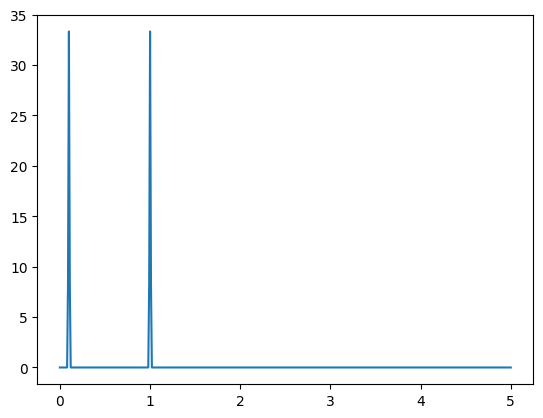

In [11]:
import matplotlib.pyplot as plt
t = np.arange(1000)
signal = np.sin(t * 2*np.pi /100) + np.sin(t * 2*np.pi /10)
# plt.plot(t, signal)
f, Pxx_den = welch(signal, 10, nperseg=1024)
plt.plot(f, Pxx_den)

print(f[np.argmax(Pxx_den)])

In [76]:
def compute_quadratic_fitting(y):
    x = np.array(list(range(y.shape[-1])))
    n = len(x)
    sum_x = np.sum(x)
    sum_x2 = np.sum(x**2)
    sum_x3 = np.sum(x**3)
    sum_x4 = np.sum(x**4)
    sum_y = np.sum(y, axis=2)
    sum_xy = np.sum(x*y, axis=2)
    sum_x2y = np.sum((x**2)*y, axis=2)

    # Create the coefficient matrix A and Y
    A = np.array([[sum_x4, sum_x3, sum_x2],
                  [sum_x3, sum_x2, sum_x],
                  [sum_x2, sum_x, n]])
    Y = np.array([sum_x2y, sum_xy, sum_y])

    # Solve the linear system
    a, b, c = np.linalg.solve(A, Y)
    
    # Concatenating coefficients a, b, and c
    concatenate_abc = np.concatenate((a[..., np.newaxis], b[..., np.newaxis], c[..., np.newaxis]), axis=-1)
    return concatenate_abc  # coefficients a, b, and c

# Test with random input data
input_data = np.random.rand(3, 2, 10)
time = np.array(list(range(input_data.shape[-1])))
output = compute_quadratic_fitting(input_data)
print(output.shape)

(3, 2, 3)


(428, 52, 9)


Text(0.5, 0, 'Time(s)')

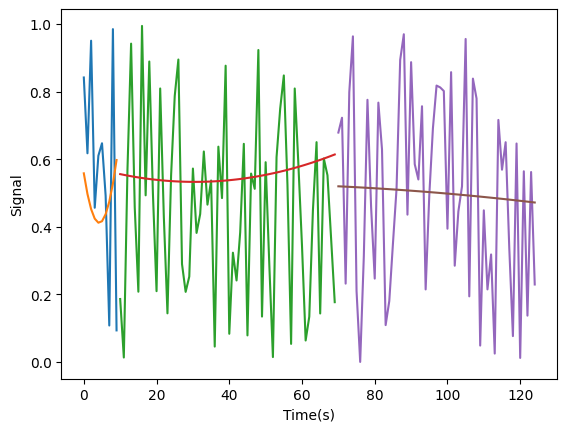

In [10]:
# A demo of feature_8

input_data = np.random.rand(428,52,125)
time = np.array(list(range(input_data.shape[-1])))

feature_8 = np.zeros((428,52,9))
print(feature_8.shape)
for i in range(428):
    for j in range(52):
        # Fit a quadratic function (degree 2 polynomial) to the data
        # coefficients[0] is a, coefficients[1] is b, and coefficients[2] is c in the equation ax^2 + bx + c
        a1, b1, c1  = np.polyfit(time[:index_task_start], input_data[i,j,:index_task_start], 2)  # the 2 specifies a quadratic function
        a2, b2, c2  = np.polyfit(time[index_task_start:index_task_end], input_data[i,j,index_task_start:index_task_end], 2)
        a3, b3, c3  = np.polyfit(time[index_task_end:], input_data[i,j,index_task_end:], 2)
        feature_8[i,j] = [a1,b1,c1,a2,b2,c2,a3,b3,c3]
# plt.plot(time, time**2*a + time*b + c)
plt.plot(time[:index_task_start], input_data[i,j,:index_task_start])
plt.plot(time[:index_task_start], time[:index_task_start]**2*feature_8[0,0,0] + time[:index_task_start]*feature_8[0,0,1] + feature_8[0,0,2])

plt.plot(time[index_task_start:index_task_end], input_data[i,j,index_task_start:index_task_end])
plt.plot(time[index_task_start:index_task_end], time[index_task_start:index_task_end]**2*feature_8[0,0,3] + time[index_task_start:index_task_end]*feature_8[0,0,4] + feature_8[0,0,5])

plt.plot(time[index_task_end:], input_data[i,j,index_task_end:])
plt.plot(time[index_task_end:], time[index_task_end:]**2*feature_8[0,0,6] + time[index_task_end:]*feature_8[0,0,7] + feature_8[0,0,8])

plt.ylabel('Signal')
plt.xlabel('Time(s)')

In [50]:
time = np.array(list(range(100)))
input = np.random.randn(100,100,100)
linear = compute_linear_fitting(input)

print(linear.shape)
# for i in range(5):
#     for j in range(5):
#         plt.figure()
#         plt.plot(time, input[i,j,:])
#         plt.plot(time, time*linear[i,j,0] + linear[i,j,1])

(100, 100, 2)


In [45]:
con = np.concatenate(compute_linear_fitting(input), axis=-1)
print(con.shape)

(100, 200)
